**SECTION OBJECTIVES**
* Preparing dataset for **Binary Classification**
* Creating a **Logistic Regression** model to predict severe damage
* Explaining model prediction using **odds ratio**

**ML WORKFLOW**
* Preparing Data
    * Importing: Binary Target (severely damaged or not severely damaged buildings)
    * Exploring: Class Balance (what proportion were or were not severely damaged)
    * Splitting: Randomised train-test split
* Building Model
    * Baselining: Accuracy Score
    * Iterating: Logistic Regression (for Classification)
    * Evaluating: Accuracy Score
* Communicating Results
    * Odds Ratio

In [1]:
# Importing necessary libraries

import sqlite3
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Preparing Data
## 1.1 Importing Data
* Creating a wrangle function which returns the results of SQL query as a Dataframe (but since don't have access to sql file, will use the saved csv as data source)
* 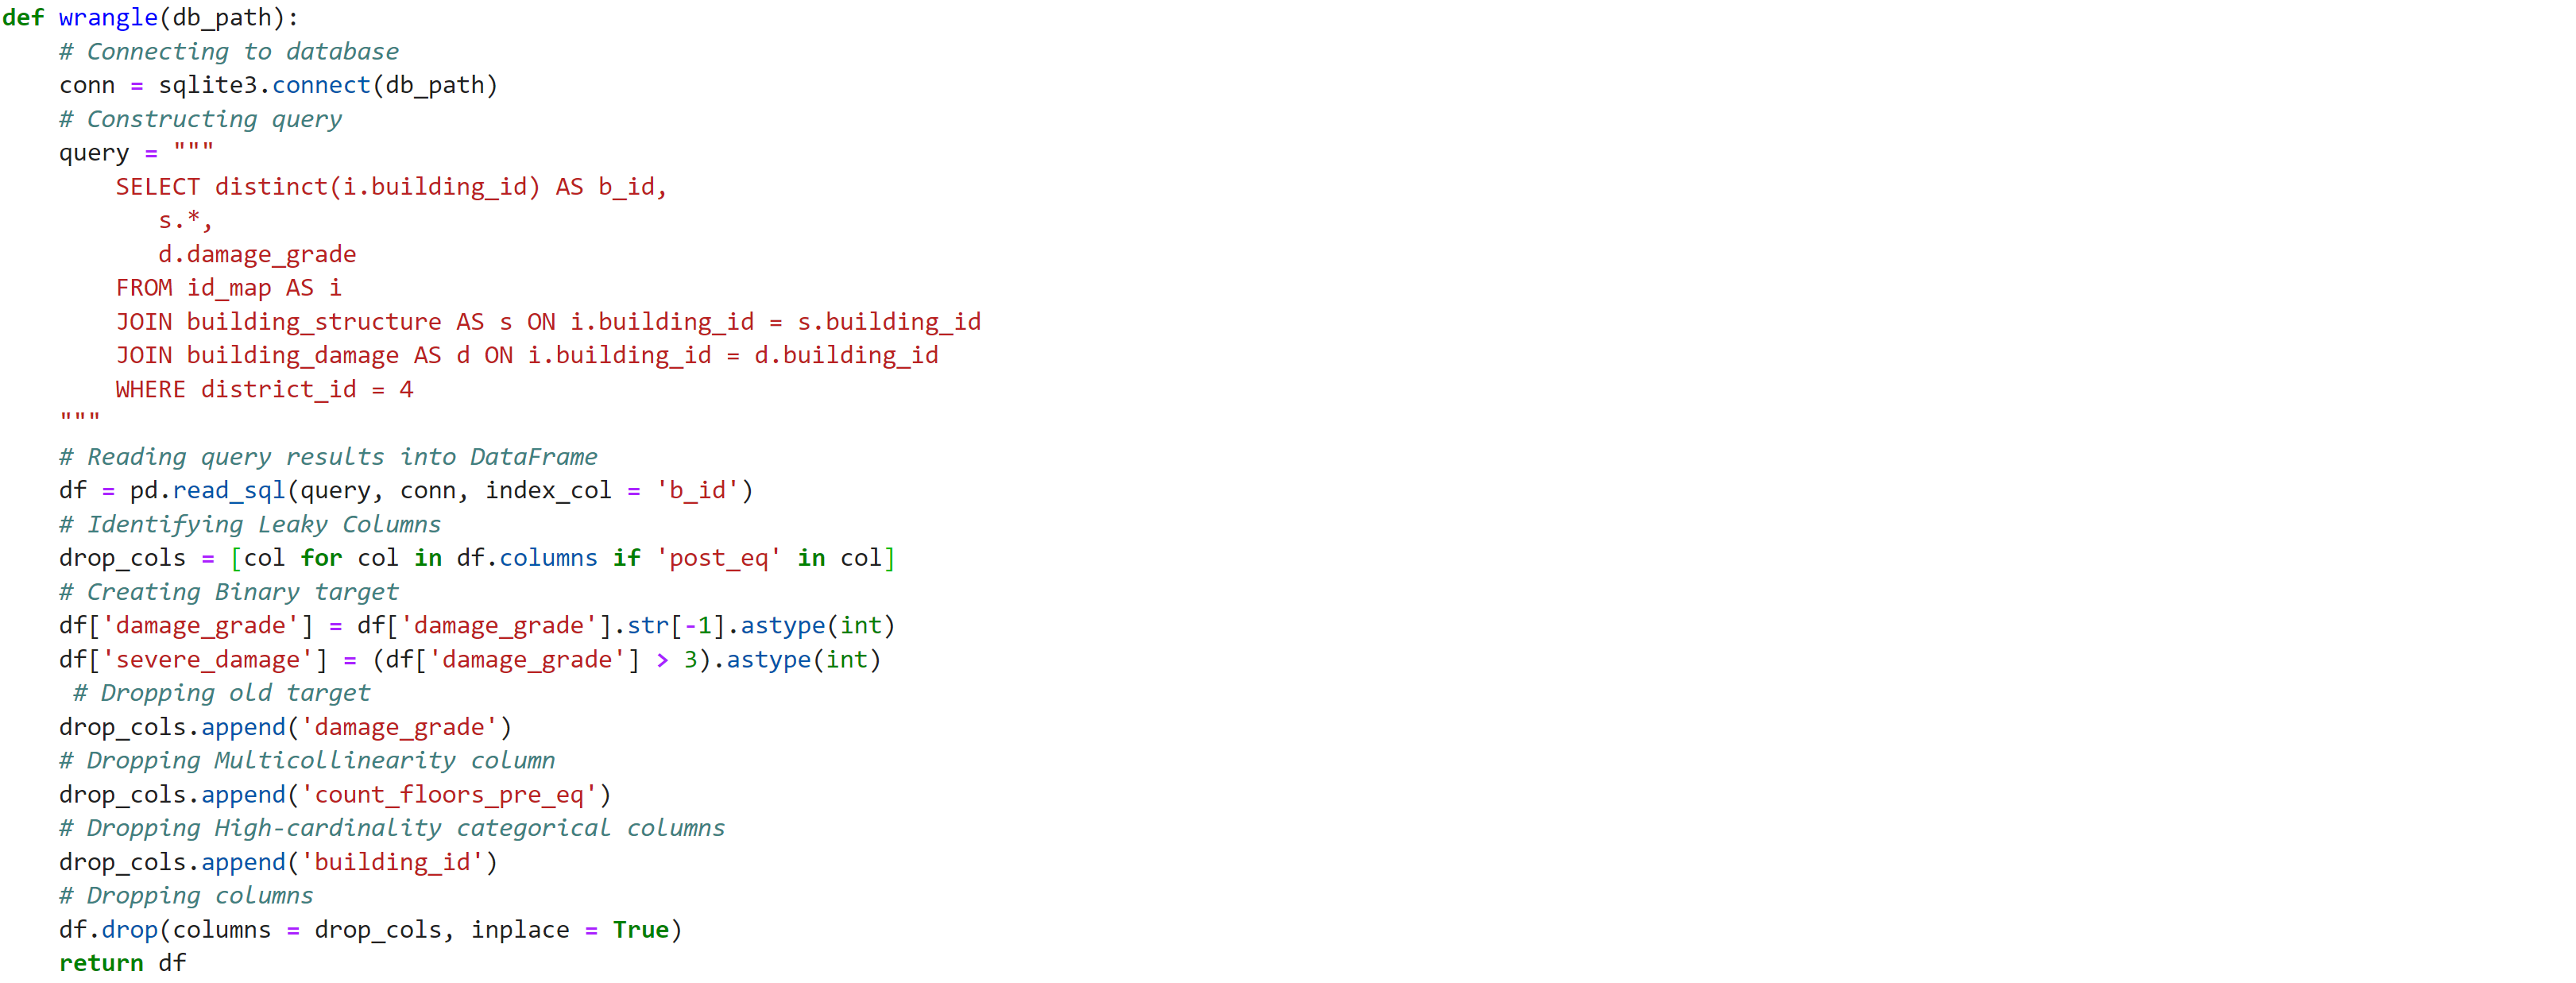
### Dropping Leaky Features
* Before model building begins, it is imperative to purge features which might give unfair information to predictor
* Leaky features here are those which describe the building condition post-earthquake
* such as `count_floors_post_eq` or `height_ft_post_eq` or `condition_post_eq`
* **List Comprehension** would be used for this purpose

In [2]:
def wrangle(filepath):
    
    # Importing data from csv file
    df = pd.read_csv(filepath, index_col = 'b_id')
    
    # Identifying leaky columns (columns with `post_eq` in string)
    drop_cols = [col for col in df.columns if 'post_eq' in col]
    
    # Dropping leaky columns
    df.drop(columns = drop_cols, inplace = True)
    
    return df    

In [3]:
df = wrangle('nepal_eq_data.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70836 entries, 164002 to 234835
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   building_id             70836 non-null  int64 
 1   count_floors_pre_eq     70836 non-null  int64 
 2   age_building            70836 non-null  int64 
 3   plinth_area_sq_ft       70836 non-null  int64 
 4   height_ft_pre_eq        70836 non-null  int64 
 5   land_surface_condition  70836 non-null  object
 6   foundation_type         70836 non-null  object
 7   roof_type               70836 non-null  object
 8   ground_floor_type       70836 non-null  object
 9   other_floor_type        70836 non-null  object
 10  position                70836 non-null  object
 11  plan_configuration      70836 non-null  object
 12  superstructure          70836 non-null  object
 13  damage_grade            70836 non-null  object
dtypes: int64(5), object(9)
memory usage: 8.1+ MB
Non

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,damage_grade
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 2
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 2
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 2
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 3
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 3


### Binary Classification Feature
* Buildings need to be divided into severely damaged and not-severely damaged
* That information can be found in `damage_grade`
* But Data type for `damage_grade` is object. It needs to be converted for it to be of use

In [4]:
df['damage_grade'].head()

b_id
164002    Grade 2
164081    Grade 2
164089    Grade 2
164098    Grade 3
164103    Grade 3
Name: damage_grade, dtype: object

In [5]:
# Getting value counts for `damage_grade` for more info on types of damage
df['damage_grade'].value_counts()

Grade 5    24869
Grade 4    20650
Grade 3    14097
Grade 2     7650
Grade 1     3570
Name: damage_grade, dtype: int64

* **POSITIVE CLASS** Grade 5 and Grade 4 are the most severely damaged buildings. They can be classified together as **1**
* **NEGATIVE CLASS** Grade 1, 2, 3 are less severely damaged and can be classified as **0**

In [6]:
# Pulling last string character from `damage_grade`, changing to dtype integer and overwriting `damage_grade` column
df['damage_grade'] = df['damage_grade'].str[-1].astype(int)

In [7]:
# Creating a `severe_damage` column. Astype `int` converts Boolean True to 1 and False to 0
df['severe_damage'] = (df['damage_grade'] > 3).astype(int)

In [8]:
# Dropping 'damage_grade' column as it is a leaky feature now
df.drop(columns='damage_grade', inplace = True)
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [9]:
# Counting values in `severe_damage` column
print(df['severe_damage'].value_counts())

1    45519
0    25317
Name: severe_damage, dtype: int64


## 1.2 Exploring Data
### Correlation Heatmap
* Logistic Regression models although are for Classification, but they are in the same group as other Linear Models.
* Any correlation must be eliminated before model building
* Checking for Multicollinearity

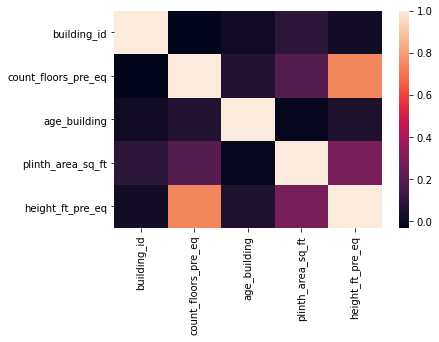

In [10]:
# Creating Correlation Matrix for only numerical features. Excluding the target `severe_damage`
correlation = df.select_dtypes('number').drop(columns='severe_damage').corr()

# Plottting a heatmap for 'correlation'
sns.heatmap(correlation);

* We can see the number of floors is correlated to the height of buildings
* So one of these features must be dropped. But which one?
* **When deciding which of the correalted feature to drop, it is best to drop the feature which has least predictive power on target vector**
* In other words, drop the feature which is least correlated to the target vector

In [11]:
# Comparing correlation of `severe_damage` with `count_floors_pre_eq` and `height_ft_pre_eq`
print((df['severe_damage']).corr(df['count_floors_pre_eq']))
print((df['severe_damage']).corr(df['height_ft_pre_eq']))                                 

0.002892630372575254
-0.03847659083302029


* It turns out that the number of floors in a building is less strongly correlated to the target vector `severe_damage`
* So it can be dropped and height of the building pre eq should be preferred
#### Dropping Multicollinearity Column

In [12]:
df.drop(columns='count_floors_pre_eq', inplace = True)
df.head()

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,
164002,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


### Seaborn Boxplot
* Identifying relationships between target and other features in dataset
* Here we have categorical as well as continuous variables
* **Numerical Feature** Spotting any obvious differences between houses that were severely damaged in the earthquake (`"severe_damage"==1`) those that were not (`"severe_damage"==0`)

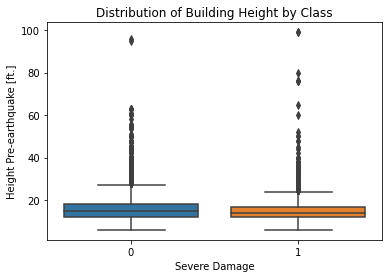

In [13]:
# Creating boxplot which shows distributions of `height_ft_pre_eq` column for both groups in `severe_damage` column
sns.boxplot(x = 'severe_damage', y = 'height_ft_pre_eq', data = df)

# Labeling axes. Since seaborn is built on matplotlib, those tools can be used
plt.xlabel('Severe Damage')
plt.ylabel('Height Pre-earthquake [ft.]')
plt.title('Distribution of Building Height by Class');

* This plot shows almost identical distribution of buildings which did and did not suffer severe damage
* From a model building perspective, it might have helped more if there were large gap in height between damaged and less damaged buildings

### Class Balance Bar Chart
* Relative proportion of less severely damaged and more severely damaged buildings


In [14]:
# Normalising values for `severe_damage` column
df['severe_damage'].value_counts(normalize=True)

1    0.642597
0    0.357403
Name: severe_damage, dtype: float64

It turns out that almost 65% of buildings were severely damaged

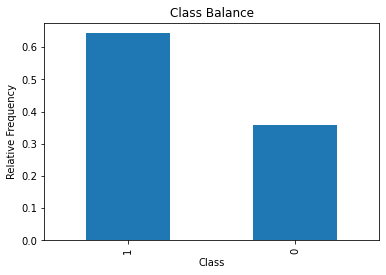

In [15]:
# Plotting value counts of `severe_damage`
df['severe_damage'].value_counts(normalize=True).plot(
    kind = 'bar', xlabel = 'Class', ylabel = 'Relative Frequency', title = 'Class Balance'
);

* If these classes were super-imbalanced (90-10 or more) more manipulation would have needed to be done to ensure model performs well
* **MAJORITY CLASS** is the Postive Class here (1, Severely Damaged)

### Majority and Minority Classes


In [16]:
majority_class_prop, minority_class_prop = df['severe_damage'].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


### Pivot Table
* Creating a pivot table of `df` where the index is `"foundation_type"` and the values come from the `"severe_damage"` column, aggregated by the mean
* Pivot Table converts 'long and narrow' dataframe to 'short and wide'

In [17]:
foundation_pivot = pd.pivot_table(
    df, index = 'foundation_type', values = 'severe_damage', aggfunc = np.mean
).sort_values(by = 'severe_damage')
foundation_pivot

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


* On Left is the index with different types of foundations
* On right is the percentage of buildings with that foundation which were severely damaged

### Bar Chart: Damage by Foundation
* Plotting `foundation_pivot` as horizontal bar chart, adding vertical lines at the values for `majority_class_prop` and `minority_class_prop`.

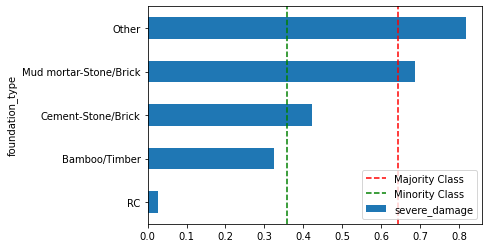

In [18]:
foundation_pivot.plot(kind = 'barh', legend = None)
# Adding vertical line which demarcates boundary between majority and minority classes
plt.axvline(
    majority_class_prop, linestyle = '--', color = 'red', label = 'Majority Class'
)
plt.axvline(
    minority_class_prop, linestyle = '--', color = 'green', label = 'Minority Class'
)
plt.legend(loc = 'lower right');

* The reason for plotting Majority and Minority Class lines is to find foundation types which are above and below the region between these lines
* It tells us that particular foundation type leg to a smaller or larger proportion than normal
* It can be see that buildings with `Other` foundation type had a higher proportion of severe damage
* And buildings with `RC` (Reinforced Concrete) foundation suffered less damage

### High-Cardinality Features

* Combining the `select_dtypes` and `nunique` methods to see if there are any high- or low-cardinality categorical features in the dataset

In [19]:
df.head()

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,
164002,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [20]:
# Checking unique values in categorical features
df.select_dtypes('object').nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

* Nothing seems out of ordinary here
* But if we look at the dataframe, building_id is not being represented as a categorical feature
    * The id does not add any value to prediction model and can be removed
    * This number is essentially a substitution for a house name
* `building_id` column needs to be dropped

In [21]:
df.drop(columns = 'building_id', inplace = True)

## 1.3 Splitting Data
### Vertical Splitting

In [22]:
target = 'severe_damage'
X = df.drop(columns = target)
y = df[target]

### Horizontal Splitting
#### Randomised Train-Test Split
* The idea of randomness needs to be balanced with model reproducibility
    * Put `random_state` (or random seed) argument in `train_test_split` as 42

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


# 2. Building Model
## 2.1 Baselining Accuracy Score
* Mean Absolute Error does not work on Classification, because a discrete answer is required
    * Either something belongs to one class or not
* **Accuracy Score is one of the metrics to evaluate Classification Models**
    * Accuracy Score indicates how many predictions were right
    * Acuuracy Score lies somewhere between 0 and 1
* In our case if we could make only one guess, it would make sense to guess the prediction as Majority Class i.e. the building is severely damaged

In [24]:
# Calculating value counts for target training data and normalising them
y_train.value_counts(normalize = True)

1    0.641032
0    0.358968
Name: severe_damage, dtype: float64

**The accuracy baseline is the maximum of normalised value from above**

In [25]:
acc_baseline = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', round(acc_baseline, 2))

Baseline Accuracy: 0.64


**In order for our model to add value, Accuracy Score should be greater than 0.64 and close to 1**

## 2.2 Iterating
### Logistic Regression
* **Sigmoid function** That's what the curve looks like. 
* The output is a probability between 0-1
* Any prediction above cutoff line (generally 0.5) is part of Positive Class (1)
* Any prediction below cutoff line is part of Negative Class (0)
* **CONVERGENCE WARNING**
    * Common with Logistic Regression models. Shows that maximum number of default iterations was reached before model converged at an outcome
    * Use `max_iter` to raise number of iterations

In [27]:
# Building model
model = make_pipeline(
    OneHotEncoder(use_cat_names = True), # Encoding categorical features
    LogisticRegression(max_iter = 1000) # Setting max_iter to 1000 to avoid Convergence Warning
)
# Fitting model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## 2.3 Evaluating
* Calculating training and test accuracy scores for the model
* Two ways to do it

In [28]:
# Method 1 to calculate model's accuracy score for training set
accuracy_score(y_train, model.predict(X_train))

0.7136126208795087

In [30]:
# Method 2: `model.score()` returns accuracy score by default in case of Classification models (Logistic Regression in this case)
model.score(X_test, y_test) # calculating accuracy score for test set

0.7223320158102767

In [31]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.71
Test Accuracy: 0.72


**The model beats baseline accuracy score. That's good news**

# 3. Communicating Results
## 3.1 Predicting Probability
* Logistic Regression sits upon a probability estimate
* It can often be helpful to see the probability using `predict_proba`

In [32]:
# Checking first 5 predictions
model.predict(X_train)[:5]

array([0, 1, 1, 1, 1])

In [33]:
# Checking probabilities behind these predictions
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.96737078 0.03262922]
 [0.48039514 0.51960486]
 [0.34647557 0.65352443]
 [0.4053056  0.5946944 ]
 [0.33172398 0.66827602]]


* The output is a nested list
* **The column on the Left are Negative Class (0)**
* **The column on the right are Positive Class (1) (Severely Damaged)**

#### Extracting Feature Names and Importances

In [34]:
features = model.named_steps['onehotencoder'].get_feature_names()
importances = model.named_steps['logisticregression'].coef_[0]

## 3.2 Odds Ratios

In [37]:
odds_ratios = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratios.head()

superstructure_Brick, cement mortar    0.276472
foundation_type_RC                     0.347366
roof_type_RCC/RB/RBC                   0.381009
ground_floor_type_RC                   0.483997
other_floor_type_RCC/RB/RBC            0.542909
dtype: float64

### Plotting Odds Ratios for largest Coefficients

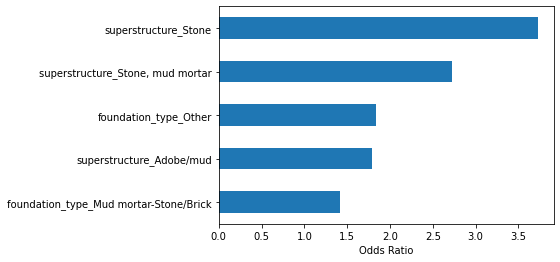

In [38]:
# Horizontal bar charting for five largest coefficients
odds_ratios.tail().plot(kind = 'barh')
plt.xlabel('Odds Ratio');

* Visualise a vertical line at 1.0
* Let's take `superstructure_Stone`
    * Its Odds Ratio is almost 4.0
    * What this means is, all else being equal, if a building's foundation is set in stone, then it is 4 times more likely (400%) to suffer severe damage in an earthquake event
* **Any Odds Ratio over 1 increases likelihood that the building would be severely damaged**

### Plotting Odds Ratios for smallest Coefficients

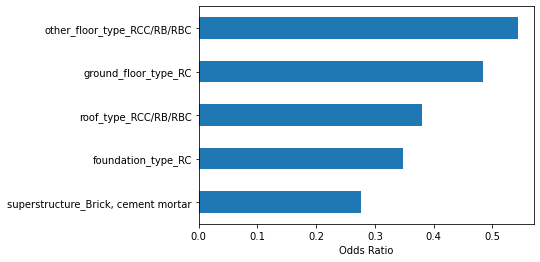

In [39]:
odds_ratios.head().plot(kind = 'barh')
plt.xlabel('Odds Ratio');

* Everything is below 1
* Smallest Odds Ratio is `superstructure_brick, cement mortar` almsot 0.25
    * **It means that having a superstructure of brick/cement mortar reduces the likelihood of a building getting severely damaged by 75%** or by a factor of 4
* Same is the case with `foundation_type_RC` with Odds Ratio 0.35
    * If a building has Reinforced Concrete foundation then it is 3 times less likely or almost 66% less likely to suffer severe damage in case of an earthquake event